In [1]:
year=2019
month=9

In [2]:
import pandas as pd
import sys
sys.path.append('../../py')
import db
import weighted
import inspect
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import scipy.stats as stats
import numpy as np
import math


In [3]:
from matplotlib.font_manager import _rebuild

_rebuild() #reload一下

In [4]:
conn=db.get_conn()
cities = "('北京','上海','深圳','杭州','广州','南京','成都','东莞','西安','武汉','天津','长沙','宁波','福州','大连','重庆','青岛','济南','合肥','长春','昆明','郑州','沈阳','哈尔滨')"
data_original=pd.read_sql(sql=f"select * from _{year}{month:02} where monthly_salary>0 and monthly_salary<80000 and city in {cities}", con=conn)
conn.close()

In [5]:
error_job_ids=['104660258','104142922','108434795','101357291','106253516','110368302','111391233','108665401','109277048'
                  ,'73857191','108584955','102824950','102824949','111391233','110884556']
data=data_original[~data_original.job_id.isin(error_job_ids)]

In [6]:
del data['publish_date']
del data['published_on_weekend']
del data['title']
del data['company_title']
del data['company_description']
del data['job_description']
del data['job_id']

In [7]:
#Common Functions
def get_sub_stats_by_col(data, col):
    categories=data[col].unique()
    salary_mean=[]
    salary_95_min=[]
    salary_95_max=[]
    salary_median=[]

    count=[]
    
    categorys_out=[]
    for category in categories:
        #print(feature)
        idata=data[data[col]==category]
        headcount=idata.headcount.sum()
        values = idata.monthly_salary.values
        weights = idata.headcount.values
        #print(str(headcount))
        if headcount==0:
            continue
        
        salary_mean.append(np.average(values, weights=weights))
        

        q = weighted.weighted_quantile(values,[0.025,0.5,0.975],weights)
        salary_95_min.append(q[0])
        salary_median.append(q[1])
        salary_95_max.append(q[2])
        count.append(idata.headcount.sum())
        categorys_out.append(category)
    sub_data=pd.DataFrame()
    sub_data[col]=[c for c in categorys_out]
    sub_data['平均工资']=salary_mean
    sub_data['最低工资']=salary_95_min
    sub_data['中位数']=salary_median
    sub_data['最高工资']=salary_95_max
    sub_data['招聘人数']=count
    sub_data['百分比']=count/np.sum(count)
    sub_data=sub_data.sort_values(by='平均工资', ascending=False)

    return sub_data

data_format={"百分比":"{:.2%}","平均工资":"{:.0f}","中位数":"{:.0f}","最低工资":"{:.0f}","最高工资":"{:.0f}"}

translate_dict={}


# 程序员工资

In [8]:
data_city=get_sub_stats_by_col(data,'city')
data_city.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
1,北京,17224,3750,15000,45000,26430,10.30%
2,上海,16542,5250,15000,37500,45927,17.90%
9,深圳,16220,5250,14500,37500,39148,15.26%
3,杭州,14980,3750,12500,35000,13890,5.41%
4,广州,13527,3750,12500,30000,29490,11.49%
8,南京,13393,4500,12500,27500,14247,5.55%
6,成都,12263,3000,11500,30000,12096,4.71%
14,东莞,11591,3750,11500,24392,2901,1.13%
0,武汉,11588,3750,11000,25000,14872,5.80%
12,长沙,11140,4000,10500,25000,6440,2.51%


In [9]:
def describe(data_city, career):
    
    for index, row in data_city.iterrows():
        print(f"{year}年{month}月{row[0]}招收{career}{row[5]}人。{year}年{month}月{row[0]}{career}平均工资{row[1]:.0f}元，工资中位数{row[3]:.0f}元，其中95%的人的工资介于{row[2]:.0f}元到{row[4]:.0f}元。\r\n")


In [10]:
describe(data_city,'程序员')

2019年9月北京招收程序员26430人。2019年9月北京程序员平均工资17224元，工资中位数15000元，其中95%的人的工资介于3750元到45000元。

2019年9月上海招收程序员45927人。2019年9月上海程序员平均工资16542元，工资中位数15000元，其中95%的人的工资介于5250元到37500元。

2019年9月深圳招收程序员39148人。2019年9月深圳程序员平均工资16220元，工资中位数14500元，其中95%的人的工资介于5250元到37500元。

2019年9月杭州招收程序员13890人。2019年9月杭州程序员平均工资14980元，工资中位数12500元，其中95%的人的工资介于3750元到35000元。

2019年9月广州招收程序员29490人。2019年9月广州程序员平均工资13527元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。

2019年9月南京招收程序员14247人。2019年9月南京程序员平均工资13393元，工资中位数12500元，其中95%的人的工资介于4500元到27500元。

2019年9月成都招收程序员12096人。2019年9月成都程序员平均工资12263元，工资中位数11500元，其中95%的人的工资介于3000元到30000元。

2019年9月东莞招收程序员2901人。2019年9月东莞程序员平均工资11591元，工资中位数11500元，其中95%的人的工资介于3750元到24392元。

2019年9月武汉招收程序员14872人。2019年9月武汉程序员平均工资11588元，工资中位数11000元，其中95%的人的工资介于3750元到25000元。

2019年9月长沙招收程序员6440人。2019年9月长沙程序员平均工资11140元，工资中位数10500元，其中95%的人的工资介于4000元到25000元。

2019年9月西安招收程序员7369人。2019年9月西安程序员平均工资10888元，工资中位数10000元，其中95%的人的工资介于3750元到22500元。

2019年9月宁波招收程序员2563人。2019年9月宁波程序员平均工资10575元，工资中位数10000元，其中95%的人的工资介于3500元到21000元。

2019年9月天

In [11]:
data_location = pd.read_csv('../city_locations.csv')
data_location=data_location.set_index('city')

In [12]:
from mpl_toolkits.basemap import Basemap

In [13]:
def draw_map(data_city,headcount_scale, title):


    #cities = []
    scale = 5

    locations = [(116.407526, 39.90403),(120, 30)]
    #fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams['figure.figsize'] = [13, 13]
    #plt.figure(figsize = (10,5))
    fig, ax = plt.subplots()
    fig.title=title
    fig.figsize=(10,5)
    fig.dpi=80
    cn_map= Basemap(llcrnrlon=77, llcrnrlat=14, urcrnrlon=140, urcrnrlat=51, \
               projection='lcc', lat_1=33, lat_2=45, lon_0=100) # ‘lcc'将投影方式设置为兰伯特投影

    # load the shapefile, use the name 'states'
    cn_map.readshapefile(r'D:/data/basemap/gadm36_CHN_shp/gadm36_CHN_1', name='china', drawbounds=True, color='gray')
    cn_map.readshapefile(r'D:/data/basemap/gadm36_TWN_shp/gadm36_TWN_1', name='taiwan', drawbounds=True, color='gray')
    #geolocator = Nominatim(user_agent="my-application")



    salary_min=data_city['平均工资'].min()
    salary_max=data_city['平均工资'].max()
    salary_middle = (salary_min+salary_max)/2
    salary_scale=salary_max-salary_min

    for index, row in data_city.iterrows():
        city=row[0]
        
        longitude = data_location.loc[city,'longitude']
        latitude = data_location.loc[city,'latitude']
        salary=row[1]
        headcount=row[5]
        #color
        color_red=0
        color_green=0
        color_blue=0
        if salary>salary_middle:
            color_red = 255 #int((salary - salary_middle) / (salary_scale/2)*255)
            color_green = int((salary_max - salary) / (salary_scale/2)*255)
        else:
            color_blue = int((salary_middle - salary) / (salary_scale/2)*255)
            color_green = int((salary - salary_min) / (salary_scale/2)*255)
            color_red = int((salary - salary_min) / (salary_scale/2)*255)

        color = '#{:02x}{:02x}{:02x}'.format(color_red,color_green,color_blue)


        x, y = cn_map(longitude,latitude)
        cn_map.plot(x,y,marker='o',color=color,markersize=int(math.sqrt(headcount/headcount_scale))+8)
        #ax.annotate(city, (x,y), xytext=(5, 5), textcoords='offset points', fontsize=15)
        #"{}{:.0f}".format(city_cn, salary)
        #ax.text(x+5, y+5,city , fontweight='bold', fontsize=int(headcount/2500+12))
        fontsize=int(math.sqrt(headcount/headcount_scale))+13
        if city == '杭州':
            x=x-400000
            y=y+10000
        elif city=='广州':
            x=x-400000
            y=y+10000
        elif city=='合肥':
            x=x-300000
            y=y+10000
        elif city=='深圳':
            y=y-100000
        elif city=='南京':
            x=x-100000
        elif city=='天津':
            y=y-50000
        elif city=='上海':
            x=x+50000
        elif city=='武汉':
            y=y-50000

        ax.text(x, y, "{}{:.0f}k".format(city, np.round(salary/1000)), fontweight='bold', fontsize=fontsize, bbox={'facecolor':color, 'alpha':0.3, 'pad':0})
    ax.text(2053805, 1077845, "https://github.com/juwikuang/china_job_survey".format(city, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(205805, 107845, "https://github.com/juwikuang/china_job_survey".format(city, np.round(salary/1000)), fontweight='bold',color='#999999', fontsize=20, bbox={'facecolor':'#eeeeee', 'alpha':0.4, 'pad':0})    
    ax.text(805805, 4007845, title.format(city, np.round(salary/1000)), fontweight='bold',color='#111111', fontsize=25)    
    ax.text(805805, 3807845, "（城市大小代表招聘数量，颜色代表工资，红色最高，黄色次之，蓝最少）", fontweight='bold',color='#111111', fontsize=13)    
    #cn_map.drawcoastlines() #绘制海岸线
    #cn_map.drawcountries(linewidth=1.5) #绘制国家边界线
    plt.show()


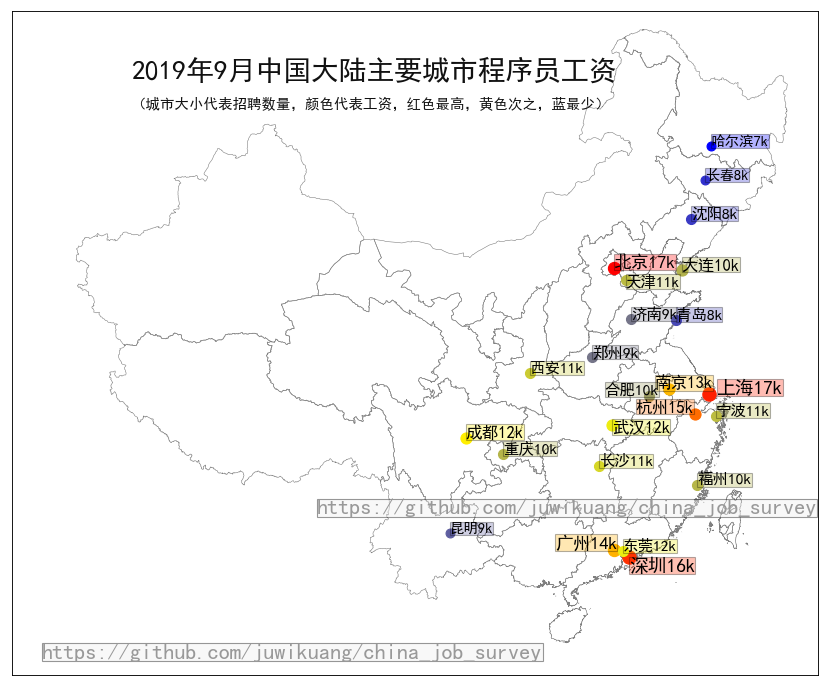

In [14]:
draw_map(data_city,2000,f'{year}年{month}月中国大陆主要城市程序员工资')

# 算法工程师

In [15]:
data_city_algorithm=get_sub_stats_by_col(data[data.career=='算法工程师'],'city')
data_city_algorithm.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
0,北京,23400,5250,22500,50000,2887,13.73%
1,上海,22963,6500,22500,48667,4524,21.52%
6,深圳,21638,6500,20000,45000,3519,16.74%
4,杭州,19791,3750,17500,45833,1452,6.91%
3,广州,18847,4787,17500,40000,2127,10.12%
10,南京,17459,7000,17000,32500,1254,5.96%
21,宁波,16373,7740,13250,35000,116,0.55%
9,成都,15479,5000,14000,31250,1021,4.86%
11,武汉,15306,4533,15000,27500,1164,5.54%
13,长沙,14697,7000,12500,32875,454,2.16%


In [16]:
describe(data_city_algorithm,'算法工程师')

2019年9月北京招收算法工程师2887人。2019年9月北京算法工程师平均工资23400元，工资中位数22500元，其中95%的人的工资介于5250元到50000元。

2019年9月上海招收算法工程师4524人。2019年9月上海算法工程师平均工资22963元，工资中位数22500元，其中95%的人的工资介于6500元到48667元。

2019年9月深圳招收算法工程师3519人。2019年9月深圳算法工程师平均工资21638元，工资中位数20000元，其中95%的人的工资介于6500元到45000元。

2019年9月杭州招收算法工程师1452人。2019年9月杭州算法工程师平均工资19791元，工资中位数17500元，其中95%的人的工资介于3750元到45833元。

2019年9月广州招收算法工程师2127人。2019年9月广州算法工程师平均工资18847元，工资中位数17500元，其中95%的人的工资介于4787元到40000元。

2019年9月南京招收算法工程师1254人。2019年9月南京算法工程师平均工资17459元，工资中位数17000元，其中95%的人的工资介于7000元到32500元。

2019年9月宁波招收算法工程师116人。2019年9月宁波算法工程师平均工资16373元，工资中位数13250元，其中95%的人的工资介于7740元到35000元。

2019年9月成都招收算法工程师1021人。2019年9月成都算法工程师平均工资15479元，工资中位数14000元，其中95%的人的工资介于5000元到31250元。

2019年9月武汉招收算法工程师1164人。2019年9月武汉算法工程师平均工资15306元，工资中位数15000元，其中95%的人的工资介于4533元到27500元。

2019年9月长沙招收算法工程师454人。2019年9月长沙算法工程师平均工资14697元，工资中位数12500元，其中95%的人的工资介于7000元到32875元。

2019年9月合肥招收算法工程师333人。2019年9月合肥算法工程师平均工资14014元，工资中位数12500元，其中95%的人的工资介于5250元到36196元。

2019年9月西安招收算法工程师556人。2019年9月西安算法工程师平均工资13726元，工资中位数12500元

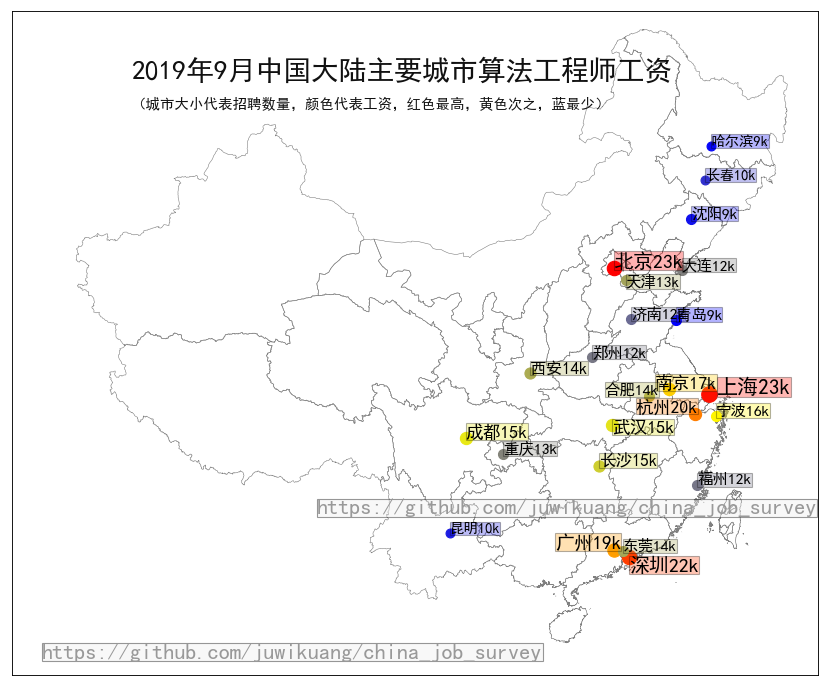

In [17]:
draw_map(data_city_algorithm,100,f'{year}年{month}月中国大陆主要城市算法工程师工资')

# 系统架构师

In [18]:
data_city_architect=get_sub_stats_by_col(data[data.career=='系统架构师'],'city')
data_city_architect.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
6,北京,31325,9367,30000,60000,1304,14.80%
8,深圳,26505,5917,25667,59562,1269,14.41%
4,上海,24710,7000,22500,50000,1952,22.16%
5,杭州,23939,7070,24000,45000,534,6.06%
2,南京,21039,7000,20000,38612,411,4.67%
3,广州,20751,5250,20000,45000,1347,15.29%
0,大连,19506,9000,17500,37500,88,1.00%
10,东莞,18679,7000,20000,29791,110,1.25%
9,成都,18551,6434,17500,43762,319,3.62%
7,西安,17766,8000,17500,38812,199,2.26%


In [19]:
describe(data_city_architect,'系统架构师')

2019年9月北京招收系统架构师1304人。2019年9月北京系统架构师平均工资31325元，工资中位数30000元，其中95%的人的工资介于9367元到60000元。

2019年9月深圳招收系统架构师1269人。2019年9月深圳系统架构师平均工资26505元，工资中位数25667元，其中95%的人的工资介于5917元到59562元。

2019年9月上海招收系统架构师1952人。2019年9月上海系统架构师平均工资24710元，工资中位数22500元，其中95%的人的工资介于7000元到50000元。

2019年9月杭州招收系统架构师534人。2019年9月杭州系统架构师平均工资23939元，工资中位数24000元，其中95%的人的工资介于7070元到45000元。

2019年9月南京招收系统架构师411人。2019年9月南京系统架构师平均工资21039元，工资中位数20000元，其中95%的人的工资介于7000元到38612元。

2019年9月广州招收系统架构师1347人。2019年9月广州系统架构师平均工资20751元，工资中位数20000元，其中95%的人的工资介于5250元到45000元。

2019年9月大连招收系统架构师88人。2019年9月大连系统架构师平均工资19506元，工资中位数17500元，其中95%的人的工资介于9000元到37500元。

2019年9月东莞招收系统架构师110人。2019年9月东莞系统架构师平均工资18679元，工资中位数20000元，其中95%的人的工资介于7000元到29791元。

2019年9月成都招收系统架构师319人。2019年9月成都系统架构师平均工资18551元，工资中位数17500元，其中95%的人的工资介于6434元到43762元。

2019年9月西安招收系统架构师199人。2019年9月西安系统架构师平均工资17766元，工资中位数17500元，其中95%的人的工资介于8000元到38812元。

2019年9月武汉招收系统架构师411人。2019年9月武汉系统架构师平均工资17538元，工资中位数17357元，其中95%的人的工资介于6055元到34075元。

2019年9月长沙招收系统架构师182人。2019年9月长沙系统架构师平均工资16567元，工资中位数15000元，其中95

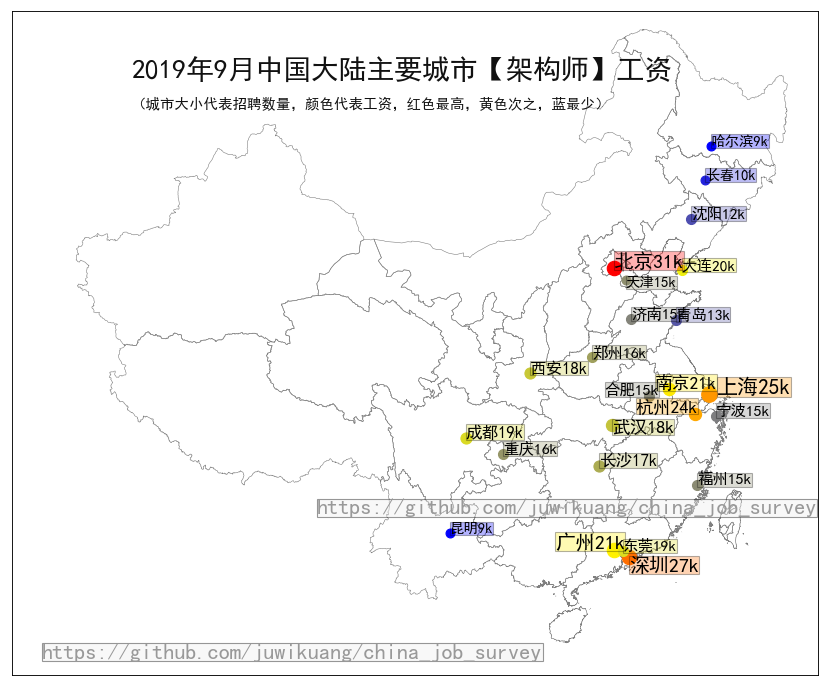

In [20]:
draw_map(data_city_architect,40,f'{year}年{month}月中国大陆主要城市【架构师】工资')

# 生物信息工程师

In [21]:
data_bio=get_sub_stats_by_col(data[data.career=='生物信息工程师'],'city')
data_bio.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
0,北京,12500,12500,12500,12500,2,7.14%
4,杭州,12000,11500,12000,12500,2,7.14%
6,长春,11500,11500,11500,11500,2,7.14%
1,广州,11375,7000,11375,14000,8,28.57%
5,上海,9800,8000,9800,12500,5,17.86%
3,武汉,9000,9000,9000,9000,1,3.57%
7,南京,9000,9000,9000,9000,3,10.71%
2,深圳,7500,7500,7500,7500,5,17.86%


In [22]:
describe(data_bio,'生物信息工程师')

2019年9月北京招收生物信息工程师2人。2019年9月北京生物信息工程师平均工资12500元，工资中位数12500元，其中95%的人的工资介于12500元到12500元。

2019年9月杭州招收生物信息工程师2人。2019年9月杭州生物信息工程师平均工资12000元，工资中位数12000元，其中95%的人的工资介于11500元到12500元。

2019年9月长春招收生物信息工程师2人。2019年9月长春生物信息工程师平均工资11500元，工资中位数11500元，其中95%的人的工资介于11500元到11500元。

2019年9月广州招收生物信息工程师8人。2019年9月广州生物信息工程师平均工资11375元，工资中位数11375元，其中95%的人的工资介于7000元到14000元。

2019年9月上海招收生物信息工程师5人。2019年9月上海生物信息工程师平均工资9800元，工资中位数9800元，其中95%的人的工资介于8000元到12500元。

2019年9月武汉招收生物信息工程师1人。2019年9月武汉生物信息工程师平均工资9000元，工资中位数9000元，其中95%的人的工资介于9000元到9000元。

2019年9月南京招收生物信息工程师3人。2019年9月南京生物信息工程师平均工资9000元，工资中位数9000元，其中95%的人的工资介于9000元到9000元。

2019年9月深圳招收生物信息工程师5人。2019年9月深圳生物信息工程师平均工资7500元，工资中位数7500元，其中95%的人的工资介于7500元到7500元。



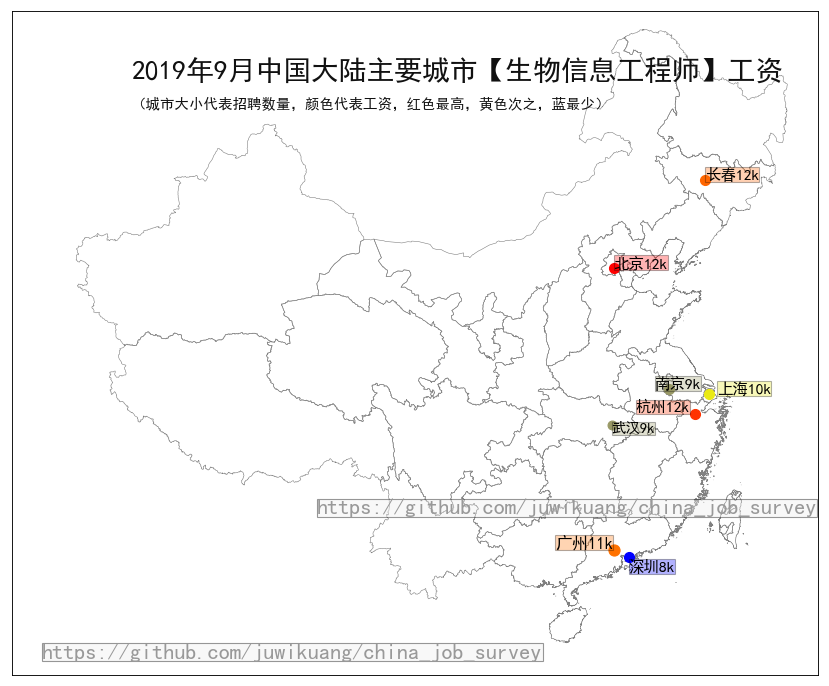

In [23]:
draw_map(data_bio,2,f'{year}年{month}月中国大陆主要城市【生物信息工程师】工资')

# 爬虫工程师

In [25]:
data_spider=get_sub_stats_by_col(data[data.career=='爬虫工程师'],'city')
data_spider=data_spider[data_spider['招聘人数']>10]
data_spider.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
6,北京,17750,1750,15000,35000,30,7.96%
1,广州,15756,2500,12357,37500,41,10.88%
9,南京,14926,12500,12500,20000,27,7.16%
3,上海,13995,5812,12500,29375,100,26.53%
5,杭州,13395,11500,12500,22500,19,5.04%
2,深圳,10793,5250,10500,21792,75,19.89%
0,武汉,10544,7000,10687,12500,19,5.04%
8,长沙,10467,9000,10500,11500,15,3.98%
10,成都,9417,6000,10000,14000,18,4.77%


In [26]:
describe(data_spider, '爬虫工程师')

2019年9月北京招收爬虫工程师30人。2019年9月北京爬虫工程师平均工资17750元，工资中位数15000元，其中95%的人的工资介于1750元到35000元。

2019年9月广州招收爬虫工程师41人。2019年9月广州爬虫工程师平均工资15756元，工资中位数12357元，其中95%的人的工资介于2500元到37500元。

2019年9月南京招收爬虫工程师27人。2019年9月南京爬虫工程师平均工资14926元，工资中位数12500元，其中95%的人的工资介于12500元到20000元。

2019年9月上海招收爬虫工程师100人。2019年9月上海爬虫工程师平均工资13995元，工资中位数12500元，其中95%的人的工资介于5812元到29375元。

2019年9月杭州招收爬虫工程师19人。2019年9月杭州爬虫工程师平均工资13395元，工资中位数12500元，其中95%的人的工资介于11500元到22500元。

2019年9月深圳招收爬虫工程师75人。2019年9月深圳爬虫工程师平均工资10793元，工资中位数10500元，其中95%的人的工资介于5250元到21792元。

2019年9月武汉招收爬虫工程师19人。2019年9月武汉爬虫工程师平均工资10544元，工资中位数10687元，其中95%的人的工资介于7000元到12500元。

2019年9月长沙招收爬虫工程师15人。2019年9月长沙爬虫工程师平均工资10467元，工资中位数10500元，其中95%的人的工资介于9000元到11500元。

2019年9月成都招收爬虫工程师18人。2019年9月成都爬虫工程师平均工资9417元，工资中位数10000元，其中95%的人的工资介于6000元到14000元。



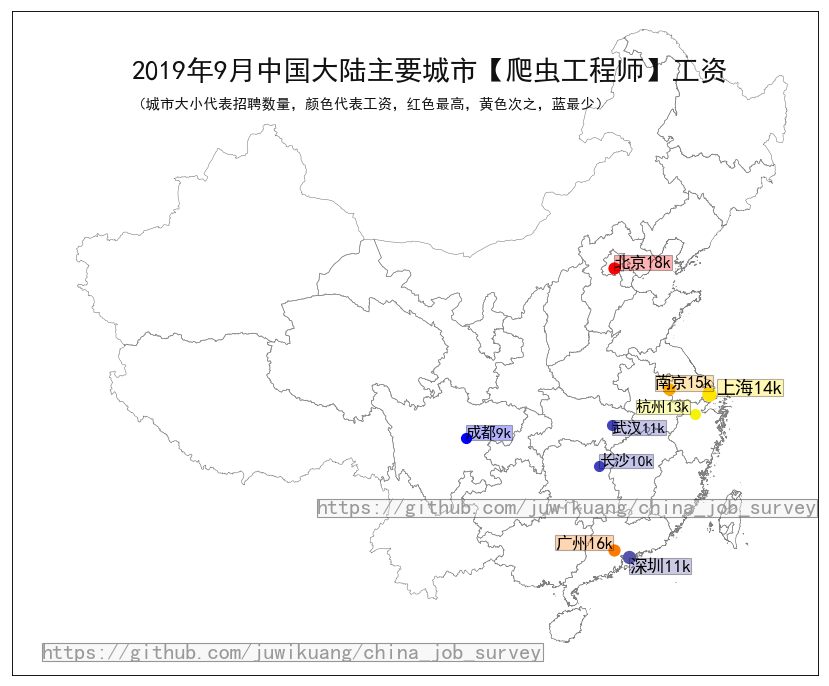

In [27]:
draw_map(data_spider,5,f'{year}年{month}月中国大陆主要城市【爬虫工程师】工资')

# Java程序员

In [28]:
data_java=get_sub_stats_by_col(data[(data.pl_java==1)],'city')
data_java.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
6,上海,16881,5500,15000,35000,20107,16.81%
7,深圳,16717,6500,15000,37500,17038,14.25%
4,北京,16136,3750,14000,37500,12755,10.66%
1,杭州,15252,3750,13500,32500,6887,5.76%
2,广州,13781,3750,12500,30000,14263,11.93%
5,南京,13214,4500,12500,25000,7802,6.52%
17,东莞,12156,3762,12500,24725,1067,0.89%
3,成都,11922,2500,11500,25000,5052,4.22%
0,武汉,11364,3838,10500,25000,5930,4.96%
8,大连,10945,2500,9000,29723,5798,4.85%


In [29]:
describe(data_java, 'Java程序员')

2019年9月上海招收Java程序员20107人。2019年9月上海Java程序员平均工资16881元，工资中位数15000元，其中95%的人的工资介于5500元到35000元。

2019年9月深圳招收Java程序员17038人。2019年9月深圳Java程序员平均工资16717元，工资中位数15000元，其中95%的人的工资介于6500元到37500元。

2019年9月北京招收Java程序员12755人。2019年9月北京Java程序员平均工资16136元，工资中位数14000元，其中95%的人的工资介于3750元到37500元。

2019年9月杭州招收Java程序员6887人。2019年9月杭州Java程序员平均工资15252元，工资中位数13500元，其中95%的人的工资介于3750元到32500元。

2019年9月广州招收Java程序员14263人。2019年9月广州Java程序员平均工资13781元，工资中位数12500元，其中95%的人的工资介于3750元到30000元。

2019年9月南京招收Java程序员7802人。2019年9月南京Java程序员平均工资13214元，工资中位数12500元，其中95%的人的工资介于4500元到25000元。

2019年9月东莞招收Java程序员1067人。2019年9月东莞Java程序员平均工资12156元，工资中位数12500元，其中95%的人的工资介于3762元到24725元。

2019年9月成都招收Java程序员5052人。2019年9月成都Java程序员平均工资11922元，工资中位数11500元，其中95%的人的工资介于2500元到25000元。

2019年9月武汉招收Java程序员5930人。2019年9月武汉Java程序员平均工资11364元，工资中位数10500元，其中95%的人的工资介于3838元到25000元。

2019年9月大连招收Java程序员5798人。2019年9月大连Java程序员平均工资10945元，工资中位数9000元，其中95%的人的工资介于2500元到29723元。

2019年9月长沙招收Java程序员3163人。2019年9月长沙Java程序员平均工资10754元，工资中位数10500元，其中95%的人的工资介于3750元到22500元。

2019年9月

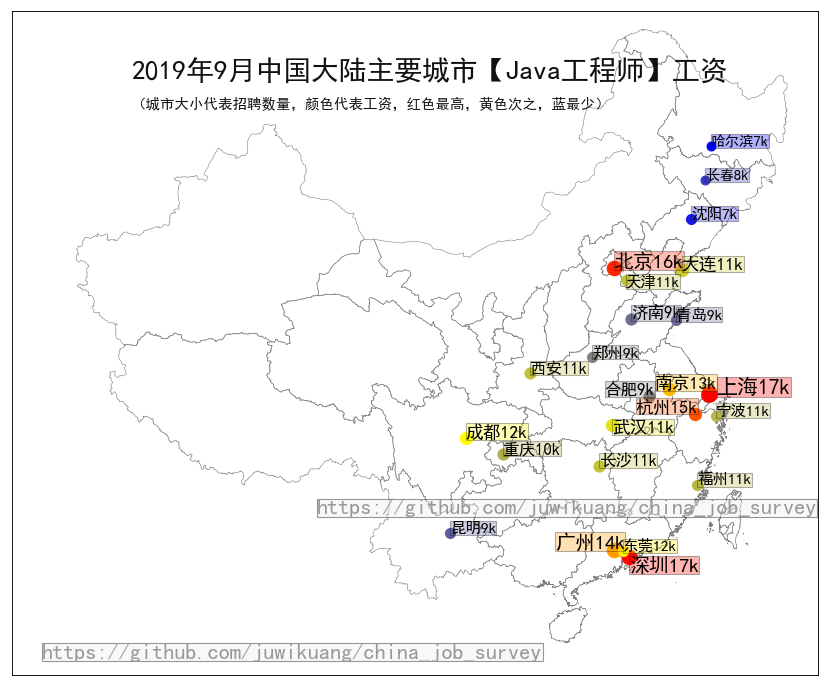

In [30]:
draw_map(data_java, 500, f'{year}年{month}月中国大陆主要城市【Java工程师】工资')

# Python程序员

In [31]:
data_python=get_sub_stats_by_col(data[(data.pl_python==1)],'city')

data_python.style.format(data_format)

,city,平均工资,最低工资,中位数,最高工资,招聘人数,百分比
7,北京,21782,3750,20000,45000,4247,15.10%
6,深圳,21164,6500,17947,44950,4061,14.44%
4,上海,20776,6500,18750,45833,6455,22.96%
0,广州,17282,4000,15000,40000,2964,10.54%
2,杭州,16904,3858,15000,45000,1790,6.37%
9,南京,16212,6200,15000,32500,1688,6.00%
10,成都,15879,3750,14500,35000,1362,4.84%
1,武汉,14439,3600,13000,30000,1396,4.96%
11,天津,14187,5312,12500,28500,184,0.65%
20,宁波,13948,4803,12500,35000,139,0.49%


In [32]:
describe(data_python, 'Python程序员')

2019年9月北京招收Python程序员4247人。2019年9月北京Python程序员平均工资21782元，工资中位数20000元，其中95%的人的工资介于3750元到45000元。

2019年9月深圳招收Python程序员4061人。2019年9月深圳Python程序员平均工资21164元，工资中位数17947元，其中95%的人的工资介于6500元到44950元。

2019年9月上海招收Python程序员6455人。2019年9月上海Python程序员平均工资20776元，工资中位数18750元，其中95%的人的工资介于6500元到45833元。

2019年9月广州招收Python程序员2964人。2019年9月广州Python程序员平均工资17282元，工资中位数15000元，其中95%的人的工资介于4000元到40000元。

2019年9月杭州招收Python程序员1790人。2019年9月杭州Python程序员平均工资16904元，工资中位数15000元，其中95%的人的工资介于3858元到45000元。

2019年9月南京招收Python程序员1688人。2019年9月南京Python程序员平均工资16212元，工资中位数15000元，其中95%的人的工资介于6200元到32500元。

2019年9月成都招收Python程序员1362人。2019年9月成都Python程序员平均工资15879元，工资中位数14500元，其中95%的人的工资介于3750元到35000元。

2019年9月武汉招收Python程序员1396人。2019年9月武汉Python程序员平均工资14439元，工资中位数13000元，其中95%的人的工资介于3600元到30000元。

2019年9月天津招收Python程序员184人。2019年9月天津Python程序员平均工资14187元，工资中位数12500元，其中95%的人的工资介于5312元到28500元。

2019年9月宁波招收Python程序员139人。2019年9月宁波Python程序员平均工资13948元，工资中位数12500元，其中95%的人的工资介于4803元到35000元。

2019年9月长沙招收Python程序员615人。2019年9月长沙Python程序员平均工资13648元，工资中位数125

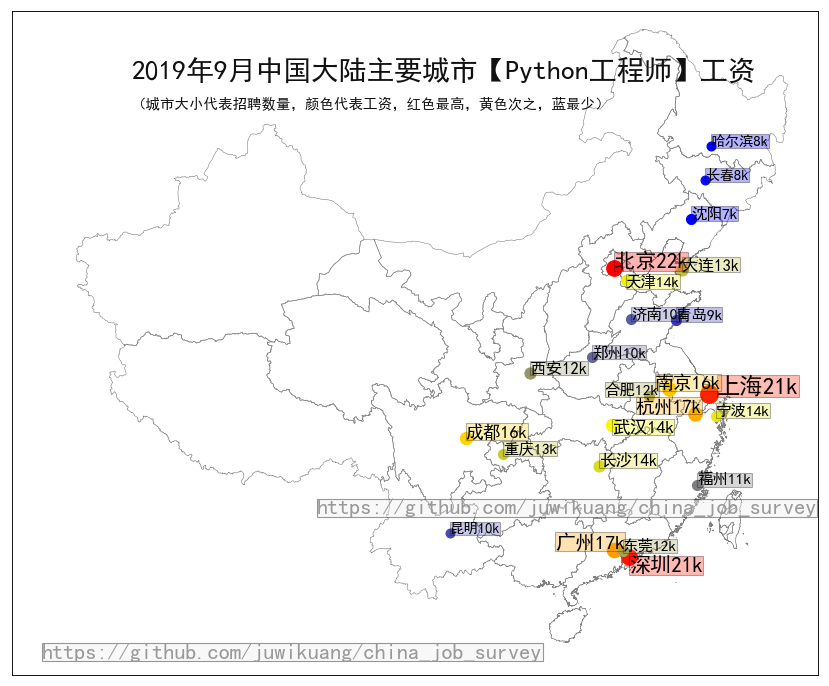

In [33]:
draw_map(data_python, 100,  f'{year}年{month}月中国大陆主要城市【Python工程师】工资')